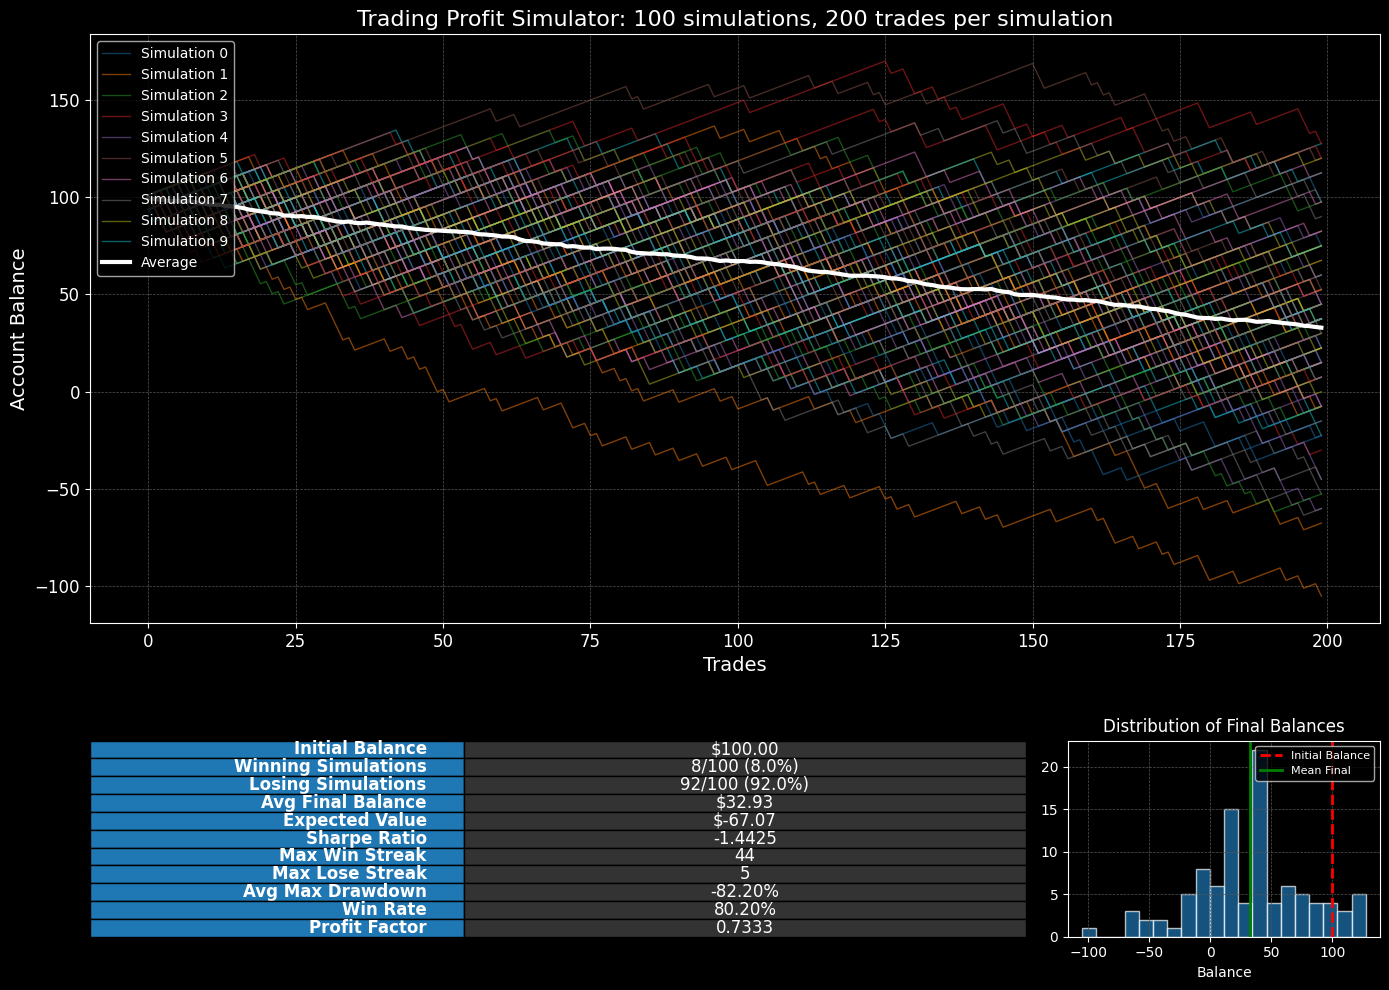

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import random
from matplotlib.gridspec import GridSpec

class Trading_Profits_Simulator:
    def __init__(self, account_balance, num_simulations, num_trades_per_simulation, win_accuracy, avg_win, avg_loss, avg_spread, commission_per_lot, avg_lot_size):
        self.account_balance = account_balance
        self.num_simulations = num_simulations
        self.num_trades_per_simulation = num_trades_per_simulation
        self.win_accuracy = win_accuracy
        self.avg_win = avg_win
        self.avg_loss = avg_loss
        self.avg_spread = avg_spread
        self.commission_per_lot = commission_per_lot
        self.avg_lot_size = avg_lot_size
        self.new_balance = account_balance
        self.all_simulations_trade_history = []
        simulation_series = []
        final_balances = []
        max_drawdowns = []
        max_win_streaks = []
        max_lose_streaks = []

        for i in range(num_simulations):
            simulation, trade_history = self.simulate(account_balance)
            simulation_series.append(simulation)
            final_balances.append(simulation.iloc[-1])
            peak = simulation.expanding().max()
            drawdown = (simulation - peak) / peak * 100
            max_drawdowns.append(drawdown.min())
            win_streak, lose_streak = self.calculate_streaks(trade_history)
            max_win_streaks.append(win_streak)
            max_lose_streaks.append(lose_streak)

            self.all_simulations_trade_history.extend(trade_history)

        self.winning_simulations = sum(1 for bal in final_balances if bal > account_balance)
        self.losing_simulations = sum(1 for bal in final_balances if bal < account_balance)
        self.break_even_simulations = sum(1 for bal in final_balances if bal == account_balance)
        self.expected_value = np.mean([bal - account_balance for bal in final_balances])
        returns = [(bal - account_balance) / account_balance for bal in final_balances]
        self.sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0
        self.overall_win_rate = sum(1 for trade in self.all_simulations_trade_history if trade > 0) / len(self.all_simulations_trade_history)
        self.avg_max_drawdown = np.mean(max_drawdowns)
        self.max_win_streak = max(max_win_streaks)
        self.max_lose_streak = max(max_lose_streaks)
        self.profit_factor = abs(sum(trade for trade in self.all_simulations_trade_history if trade > 0) /
                            sum(trade for trade in self.all_simulations_trade_history if trade < 0)) if sum(trade for trade in self.all_simulations_trade_history if trade < 0) != 0 else float('inf')
        self.plot_chart(simulation_series, final_balances)

    def simulate(self, balance):
        new_balance = balance
        data_list = []
        trade_results = []

        for i in range(self.num_trades_per_simulation):
            outcomes = ["Win", "Lose"]
            probabilities = [self.win_accuracy, 1-self.win_accuracy]
            result = random.choices(outcomes, probabilities)[0]

            if result == 'Win':
                profit = self.avg_win
            elif result == 'Lose':
                profit = self.avg_loss

            costs = (self.avg_spread * self.avg_lot_size) + (self.commission_per_lot * self.avg_lot_size)
            net_profit = profit - costs
            new_balance += net_profit
            data_list.append(new_balance)
            trade_results.append(net_profit)

        return pd.Series(data_list), trade_results

    def calculate_streaks(self, trade_history):
        current_win_streak = 0
        current_lose_streak = 0
        max_win_streak = 0
        max_lose_streak = 0

        for trade in trade_history:
            if trade > 0:  # Win
                current_win_streak += 1
                current_lose_streak = 0
                max_win_streak = max(max_win_streak, current_win_streak)
            elif trade < 0:  # Loss
                current_lose_streak += 1
                current_win_streak = 0
                max_lose_streak = max(max_lose_streak, current_lose_streak)
            else:  # Break even
                current_win_streak = 0
                current_lose_streak = 0

        return max_win_streak, max_lose_streak

    def plot_chart(self, simulation_series, final_balances):
        plt.style.use('dark_background')
        fig = plt.figure(figsize=(14, 10))
        gs = GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1])
        ax = fig.add_subplot(gs[0, :])
        table_ax = fig.add_subplot(gs[1, 0])
        table_ax.axis('off')
        hist_ax = fig.add_subplot(gs[1, 1])
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i, simulation in enumerate(simulation_series):
            color = colors[i % len(colors)]  # Cycle through the color list
            ax.plot(simulation, linestyle='-', color=color, linewidth=1, alpha=0.5, label=f'Simulation {i}' if i < 10 else "")

        avg_series = pd.DataFrame(simulation_series).mean(axis=0)
        ax.plot(avg_series, linestyle='-', color='white', linewidth=3, label='Average')

        total_simulations = len(simulation_series)
        ax.set_title(f"Trading Profit Simulator: {self.num_simulations} simulations, {self.num_trades_per_simulation} trades per simulation",
                   fontsize=16, color='white')
        ax.set_xlabel('Trades', fontsize=14, color='white')
        ax.set_ylabel('Account Balance', fontsize=14, color='white')
        ax.tick_params(axis='both', which='major', labelsize=12, colors='white')
        ax.grid(True, color='#555555', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper left', fontsize=10)
        table_data = [
            ['Initial Balance', f"${self.account_balance:.2f}"],
            ['Winning Simulations', f"{self.winning_simulations}/{total_simulations} ({self.winning_simulations/total_simulations*100:.1f}%)"],
            ['Losing Simulations', f"{self.losing_simulations}/{total_simulations} ({self.losing_simulations/total_simulations*100:.1f}%)"],
            ['Avg Final Balance', f"${np.mean(final_balances):.2f}"],
            ['Expected Value', f"${self.expected_value:.2f}"],
            ['Sharpe Ratio', f"{self.sharpe_ratio:.4f}"],
            ['Max Win Streak', f"{self.max_win_streak}"],
            ['Max Lose Streak', f"{self.max_lose_streak}"],
            ['Avg Max Drawdown', f"{self.avg_max_drawdown:.2f}%"],
            ['Win Rate', f"{self.overall_win_rate*100:.2f}%"],
            ['Profit Factor', f"{self.profit_factor:.4f}"]
        ]
        table = table_ax.table(cellText=table_data,colWidths=[0.4, 0.6],cellLoc='center',loc='center',bbox=[0.0, 0.0, 1.0, 1.0])
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)
        for i in range(len(table_data)):
            table[(i, 0)].set_text_props(color='white', weight='bold', ha='right')
            table[(i, 0)].set_facecolor('#1f77b4')
            table[(i, 1)].set_facecolor('#333333')
            table[(i, 1)].set_text_props(color='white')
        hist_ax.hist(final_balances, bins=20, color='#1f77b4', alpha=0.7, edgecolor='white')
        hist_ax.axvline(self.account_balance, color='red', linestyle='--', linewidth=2, label='Initial Balance')
        hist_ax.axvline(np.mean(final_balances), color='green', linestyle='-', linewidth=2, label='Mean Final')
        hist_ax.set_title('Distribution of Final Balances', color='white')
        hist_ax.set_xlabel('Balance', color='white')
        hist_ax.tick_params(axis='both', colors='white')
        hist_ax.grid(True, color='#555555', linestyle='--', linewidth=0.5)
        hist_ax.legend(loc='upper right', fontsize=8)

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        plt.show()

account_balance = 100
num_simulations = 100
num_trades_per_simulation = 200
win_accuracy = 0.8
avg_win = 1.5
avg_loss = -6
avg_spread_per_lot = 15
commission_per_lot = 20
avg_lot_size_traded = 0.01
simulator = Trading_Profits_Simulator(account_balance, num_simulations, num_trades_per_simulation, win_accuracy, avg_win, avg_loss, avg_spread_per_lot, commission_per_lot, avg_lot_size_traded)